# Fall Problem Session 9
## Classifying Pumpkin Seeds III

In this notebook you continue to work with the pumpkin seed data from <a href="https://link.springer.com/article/10.1007/s10722-021-01226-0">The use of machine learning methods in classification of pumpkin seeds (Cucurbita pepo L.)</a> by Koklu, Sarigil and Ozbek (2021).


The problems in this notebook will cover the content covered in some of our `Classification`, `Dimension Reduction` and our `Ensemble Learning` notebooks. In particular we will cover content touched on in:
- `Classification/Support Vector Machines`
- `Classification/Decision Trees`,
- `Ensemble Learning/Random Forests` and
- `Dimension Reduction/Principal Components Analysis`.

In [1]:
## Importing packages you will likely use
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

#### 1. Load and prepare the data

Run the code below in order to:

- Load the data stored in `Pumpkin_Seeds_Dataset.xlsx` in the `Data` folder,
- Create a column `y` where `y=1` if `Class=Ürgüp Sivrisi` and `y=0` if `Class=Çerçevelik` and
- Make a train test split setting $10\%$ of the data aside as a test set.

In [2]:
## loading the data
seeds = pd.read_excel("../Data/Pumpkin_Seeds_Dataset.xlsx")

## making a target column, y
seeds['y'] = 0

seeds.loc[seeds.Class=='Ürgüp Sivrisi', 'y']=1

In [3]:
## importing train_test_split
from sklearn.model_selection import train_test_split

In [4]:
## making a stratified train test split
seeds_train, seeds_test = train_test_split(seeds.copy(),
                                              shuffle=True,
                                              random_state=123,
                                              test_size=.1,
                                              stratify=seeds.y.values)

#### 2. Refresh your memory

If you need to refresh your memory on these data and the problem, you may want to look at a small subset of the data, look back on `Fall Problem Session 7` and `Fall Problem Session 8` and/or browse Figure 5 and Table 1 of this paper, <a href="pumpkin_seed_paper.pdf">pumpkin_seed_paper.pdf</a>

#### 3. A support vector machine classifier

In this problem you will work to build a support vector classifier on these data. Along the way you will get a closer look at iterative versions of the hyperparameter grid search. 

##### a.

Start by importing the support vector classifier from `sklearn`. Note that these data are not close to being linearly separable so we will not want `LinearSVC`.

In [5]:
## import LinearSVC here
from sklearn.svm import SVC

##### b.

You will now perform hyperparameter tuning on the `C` parameter of the support vector classifier. Fill in the missing pieces of the code below to perform 10-fold cross-validation for different values of `C`.

In [10]:
## import the correct kfold class
from sklearn.model_selection import StratifiedKFold
## import Pipeline and StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

## import accuracy_score
from sklearn.metrics import accuracy_score

In [11]:
## this will isolate the feature columns for you
features = seeds_train.columns[:-2]

In [22]:
## set the number of CV folds
n_splits = 10

## Make the kfold object
kfold = StratifiedKFold(n_splits,
                       shuffle = True,
                       random_state = 2013)

## the values of C you will try
Cs = [.01, .1, 1, 10, 25, 50, 75, 100, 125, 150]

## this will hold the CV accuracies
C_accs1 = np.zeros((n_splits, len(Cs)))


## the cross-validation loop
i = 0
for train_index, test_index in kfold.split(seeds_train, seeds_train.y):
    seeds_tt = seeds_train.iloc[train_index]
    seeds_ho = seeds_train.iloc[test_index]
    
    j = 0
    ## loop through all possible values of C
    for C in Cs:
        ## make the model, fit it and get the prediction 
        pipe = Pipeline([('scale', StandardScaler()),
                        ('svc',SVC(kernel='rbf', C=C))])
        
        pipe.fit(seeds_tt[features].values,
                   seeds_tt.y.values)
        
        pred = pipe.predict(seeds_ho[features].values)
        
        ## record the accuracy of your prediction on the holdout set
        C_accs1[i, j] = accuracy_score(seeds_ho.y, pred)
        
        j = j + 1
    i = i + 1

##### c.

Plot the average cross-validation accuracy against the $\log$ of `C`.

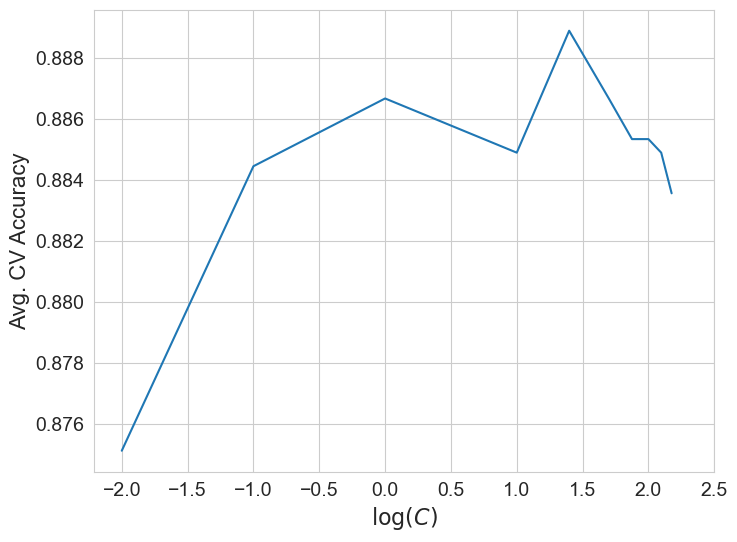

In [23]:
## make a figure object
plt.figure(figsize = (8,6))

## plot the log of C on the horizontal axis,
## the avg cv accuracy on the vertical axis
plt.plot(np.log10(Cs),C_accs1.mean(0))

## adding labels
plt.xlabel("$\log(C)$", fontsize=16)
plt.ylabel("Avg. CV Accuracy", fontsize=16)
plt.xticks(np.arange(-2,3,.5),fontsize=14)
plt.yticks(fontsize=14)

plt.show()

##### d.

A common thing that is done after one grid search is to do another grid search using values from the previous grid search as the endpoints of the grid. This is done to try and better hone in on the optimal value of the hyperparameter.

Create a new grid of `C` values using the plot you made in <i>c.</i> to determine the new endpoints. Then run cross-validation a second time. Plot the average accuracies against `C`.

In [24]:
## the values of C you will try
Cs = [1,10,20,30,40,50,60,70,80,90,100]

## this will hold the CV accuracies
C_accs2 = np.zeros((n_splits, len(Cs)))


## the cross-validation loop
i = 0
for train_index, test_index in kfold.split(seeds_train, seeds_train.y):
    seeds_tt = seeds_train.iloc[train_index]
    seeds_ho = seeds_train.iloc[test_index]
    
    j = 0
    ## looping through your new C values
    for C in Cs:
        ## make the model, fit it and get the prediction 
        pipe = Pipeline([('scale', StandardScaler()),
                        ('svc',SVC(kernel='rbf', C=C))])
        
        pipe.fit(seeds_tt[features].values,
                   seeds_tt.y.values)
        
        pred = pipe.predict(seeds_ho[features].values)
        
        ## record the accuracy of your prediction on the holdout set
        C_accs2[i, j] = accuracy_score(seeds_ho.y, pred)
        
        j = j + 1
    i = i + 1

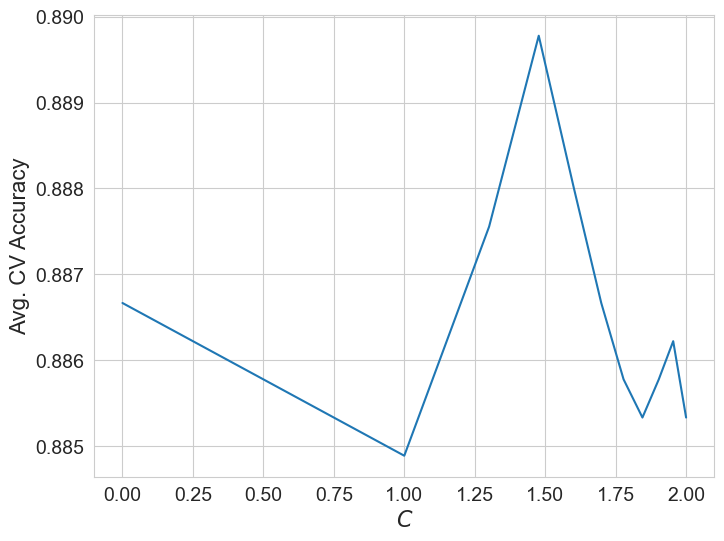

In [26]:
plt.figure(figsize = (8,6))

## Plot the C values on the horizontal axis
## plot the avg CV accuracies on the vertical axis
plt.plot(np.log10(Cs),C_accs2.mean(0))

plt.xlabel("$C$", fontsize=16)
plt.ylabel("Avg. CV Accuracy", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

##### e.

What was the optimal value of `C`, what was the average cross-validation accuracy for this value of `C`?

##### Write your answer here

#### 4. Tuning a random forest with `GridSearchCV`

In this problem you will tune the `max_depth` and `n_estimators` hyperparameters of a random forest model. First you will use a `for` loop for the cross-validation. Then you will see how much easier your life could be with `GridSearchCV`.

##### a. 

Import `sklearn`'s random forest model for classification.

In [27]:
## Import the random forest classification model
from sklearn.ensemble import RandomForestClassifier

##### b.

Fill in the code below to find the values of `max_depth` and `n_estimators` with the highest average cross-validation accuracy.

In [35]:
## note this will take about 2 minutes to run

## the possible max_depth values you'll consider
max_depths = range(1, 11)

## you'll consider n_estimators = 100, and 500
n_trees = [100, 500]


## This will record the accuracies for each loop
rf_accs = np.zeros((n_splits, len(max_depths), len(n_trees)))


i = 0
## the cross-validation loop
for train_index, test_index in kfold.split(seeds_train, seeds_train.y):
    seeds_tt = seeds_train.iloc[train_index]
    seeds_ho = seeds_train.iloc[test_index]
    
    j = 0
    ## looping through all possible max_depth values
    for max_depth in max_depths:
        k = 0
        ## looping through all possible n_estimators values
        for n_estimators in n_trees:
            print(i,j,k)
            ## make the random forest model object here
            ## set max_samples = int(.8*len(seeds_tt)) and set a random state
            pipe = Pipeline([('scale', StandardScaler()),
                        ('rf',RandomForestClassifier(max_depth = max_depth,
                                n_estimators = n_estimators,
                                random_state = 614,
                                max_samples = int(.8*len(seeds_tt))))])
        
            pipe.fit(seeds_tt[features].values,
                       seeds_tt.y.values)
            
            
            
            ## get the prediction on the holdout set
            pred = pipe.predict(seeds_ho[features].values)
            
            ## record the accuracy of the prediction
            rf_accs[i,j,k] = accuracy_score(seeds_ho.y,  pred)
            k = k + 1
        j = j + 1
    i = i + 1

0 0 0
0 0 1
0 1 0
0 1 1
0 2 0
0 2 1
0 3 0
0 3 1
0 4 0
0 4 1
0 5 0
0 5 1
0 6 0
0 6 1
0 7 0
0 7 1
0 8 0
0 8 1
0 9 0
0 9 1
1 0 0
1 0 1
1 1 0
1 1 1
1 2 0
1 2 1
1 3 0
1 3 1
1 4 0
1 4 1
1 5 0
1 5 1
1 6 0
1 6 1
1 7 0
1 7 1
1 8 0
1 8 1
1 9 0
1 9 1
2 0 0
2 0 1
2 1 0
2 1 1
2 2 0
2 2 1
2 3 0
2 3 1
2 4 0
2 4 1
2 5 0
2 5 1
2 6 0
2 6 1
2 7 0
2 7 1
2 8 0
2 8 1
2 9 0
2 9 1
3 0 0
3 0 1
3 1 0
3 1 1
3 2 0
3 2 1
3 3 0
3 3 1
3 4 0
3 4 1
3 5 0
3 5 1
3 6 0
3 6 1
3 7 0
3 7 1
3 8 0
3 8 1
3 9 0
3 9 1
4 0 0
4 0 1
4 1 0
4 1 1
4 2 0
4 2 1
4 3 0
4 3 1
4 4 0
4 4 1
4 5 0
4 5 1
4 6 0
4 6 1
4 7 0
4 7 1
4 8 0
4 8 1
4 9 0
4 9 1
5 0 0
5 0 1
5 1 0
5 1 1
5 2 0
5 2 1
5 3 0
5 3 1
5 4 0
5 4 1
5 5 0
5 5 1
5 6 0
5 6 1
5 7 0
5 7 1
5 8 0
5 8 1
5 9 0
5 9 1
6 0 0
6 0 1
6 1 0
6 1 1
6 2 0
6 2 1
6 3 0
6 3 1
6 4 0
6 4 1
6 5 0
6 5 1
6 6 0
6 6 1
6 7 0
6 7 1
6 8 0
6 8 1
6 9 0
6 9 1
7 0 0
7 0 1
7 1 0
7 1 1
7 2 0
7 2 1
7 3 0
7 3 1
7 4 0
7 4 1
7 5 0
7 5 1
7 6 0
7 6 1
7 7 0
7 7 1
7 8 0
7 8 1
7 9 0
7 9 1
8 0 0
8 0 1
8 1 0
8 1 1
8 2 0
8 2 1
8 3 

In [36]:
## This gives you the values with the best Avg CV Accuracy
max_index = np.unravel_index(np.argmax(np.mean(rf_accs, axis=0), axis=None), 
                                       np.mean(rf_accs, axis=0).shape)


print("Maximum Depth:",max_depths[max_index[0]])
print("Number of trees:",n_trees[max_index[1]])

Maximum Depth: 6
Number of trees: 500


In [37]:
## find the optimal mean CV Accuracy here here
rf_accs[:,:,:].mean(0)

array([[0.86533333, 0.86355556],
       [0.86755556, 0.86533333],
       [0.87377778, 0.87422222],
       [0.88311111, 0.88222222],
       [0.888     , 0.88977778],
       [0.88755556, 0.892     ],
       [0.88711111, 0.88977778],
       [0.88977778, 0.89111111],
       [0.88844444, 0.89155556],
       [0.89022222, 0.89155556]])

In [40]:
rf_accs[:,5,1].mean(0)

0.892

##### c.

In this problem you will learn about `GridSearchCV`, <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html">https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html</a>, a handy class from `sklearn` that makes hyperparameter tuning through a grid search and cross-validation quicker to code up than writing out a series of `for` loops.


Read through the code chunks below and fill in the missing code to run the same grid search cross-validation you did above with `GridSearchCV`.

In [42]:
## first import GridSearchCV
from sklearn.model_selection import GridSearchCV

In [46]:
## This will also take about two minutes
grid_cv = GridSearchCV(RandomForestClassifier(random_state = 614,
                                max_samples = int(.8*len(seeds_tt))), # first put the model object here
                          param_grid = {'max_depth':max_depths, # place the grid values for max_depth and
                                        'n_estimators':n_trees}, # and n_estimators here
                          scoring = 'accuracy', # put the metric we are trying to optimize here as a string, "accuracy"
                          cv = 10) # put the number of cv splits here

## you fit it just like a model, model.fit(features, target)
## fit grid_cv here

grid_cv.fit(seeds_tt[features].values,
                       seeds_tt.y.values)


GridSearchCV(cv=10,
             estimator=RandomForestClassifier(max_samples=1620,
                                              random_state=614),
             param_grid={'max_depth': range(1, 11), 'n_estimators': [100, 500]},
             scoring='accuracy')

Once a `GridSearchCV` is fit you are easily able to find what hyperparameter combinations were best, what the optimal score was as well as get access to the best model.

In [47]:
## You can find the hyperparameter grid point that
## gave the best performance like so
## .best_params_
grid_cv.best_params_

{'max_depth': 8, 'n_estimators': 500}

In [48]:
## You can find the best score like so
## .best_score_
## You try
grid_cv.best_score_

0.8928473881870946

In [49]:
## Calling best_estimator_ returns the model with the 
## best avg cv performance after it has been refit on the
## entire data set
## You try to look at the best model
grid_cv.best_estimator_

RandomForestClassifier(max_depth=8, max_samples=1620, n_estimators=500,
                       random_state=614)

The `best_estimator_` is a model with the optimal hyperparameters that has been fit on the entire training set. Try and predict the pumpkin seed class on the training set with the `best_estimator_` below.

If you want to look at all of the results, you can do that as well with `.cv_results`. See all that entails by running the code below.

In [50]:
## You can get all of the results with cv_results_
grid_cv.cv_results_

{'mean_fit_time': array([0.19157457, 0.88421223, 0.20627952, 1.02685037, 0.22348278,
        1.50786383, 0.71148257, 1.89416955, 0.28104432, 1.47779846,
        0.29873412, 1.64258182, 0.30777681, 1.62009342, 0.32801311,
        1.77542541, 0.73155265, 2.10581474, 0.3967108 , 1.66790903]),
 'std_fit_time': array([0.02718529, 0.07212274, 0.00719263, 0.03092122, 0.0093934 ,
        0.35952131, 0.38277709, 0.15404079, 0.02010726, 0.14485406,
        0.01718235, 0.31667678, 0.00948627, 0.11412048, 0.00784268,
        0.32037988, 0.18913294, 0.42029904, 0.06459894, 0.03030795]),
 'mean_score_time': array([0.01258876, 0.06403422, 0.01226878, 0.06222494, 0.0124377 ,
        0.097528  , 0.03556204, 0.08075621, 0.01569998, 0.07695625,
        0.01280377, 0.06898589, 0.01328182, 0.08139269, 0.013696  ,
        0.0730386 , 0.03396091, 0.07114944, 0.01618743, 0.06382377]),
 'std_score_time': array([0.00181394, 0.01634161, 0.00127368, 0.0033469 , 0.00089301,
        0.07207686, 0.01742966, 0.026478

##### d.

Using either the `best_estimator_` fitted model or a refitted model according to your results from the `for` loop cross-validation find the feature importance scores. Try and refer back to your notes from `Fall Problem Session 7`, how do the scores compare to your initial EDA?

In [ ]:
## code here



##### Write any notes here




In the next notebook you will build a couple of more models on these data and select a final model.

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2022.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)